# Time Series - Arima PETR3

In [19]:
# Importando bibliotecas (obs: datetime para pegar dados em sites)
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error


In [20]:
# Importando ARIMA 
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf


In [21]:
start = dt.datetime(2015,1,1)
end = dt.datetime(2020,6,30)

In [22]:
# Importando dados do yahoo finance
petr4 = web.DataReader("PETR4.SA", "yahoo", start, end)

In [23]:
petr4

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,9.990000,9.350000,9.990000,9.360000,49559500.0,8.683293
2015-01-05,9.190000,8.530000,9.140000,8.560000,78385100.0,7.941135
2015-01-06,8.830000,8.040000,8.710000,8.280000,84723300.0,7.681378
2015-01-07,8.730000,8.360000,8.560000,8.670000,85531000.0,8.043181
2015-01-08,9.390000,8.740000,8.790000,9.230000,83306300.0,8.562695
...,...,...,...,...,...,...
2020-06-24,21.559999,20.709999,21.490000,21.000000,65162400.0,20.999582
2020-06-25,21.469999,20.730000,20.910000,21.469999,47263500.0,21.469574
2020-06-26,21.469999,20.780001,21.209999,20.840000,55499300.0,20.839586


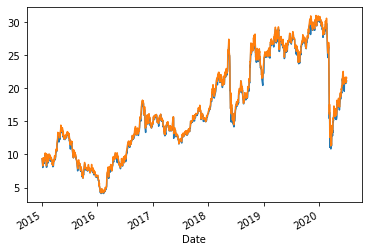

In [24]:
petr4["Low"].plot()
petr4["Close"].plot()

In [25]:
petr4_close = petr4["Close"]

In [26]:
petr4_close

Date
2015-01-02     9.360000
2015-01-05     8.560000
2015-01-06     8.280000
2015-01-07     8.670000
2015-01-08     9.230000
                ...    
2020-06-24    21.000000
2020-06-25    21.469999
2020-06-26    20.840000
2020-06-29    21.660000
2020-06-30    21.549999
Name: Close, Length: 1363, dtype: float64

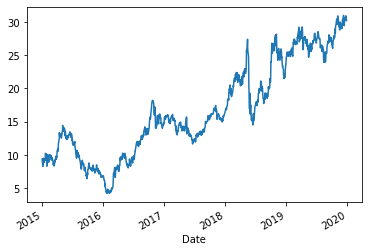

In [27]:
# Separando dados para o treino e visualizando
petr4_treino = petr4_close["2015-01-01":"2020-01-01"]
petr4_treino.plot()

In [28]:
# Existe NaNs nos dados?
print(petr4_close.isnull().values.any().sum())

0


In [29]:
# Conhecendo nossa base
petr4_close.describe()

count    1363.000000
mean       17.118944
std         7.124282
min         4.200000
25%        11.920000
50%        15.670000
75%        23.959999
max        30.969999
Name: Close, dtype: float64

In [30]:
petr4_treino.describe()

count    1241.000000
mean       16.663739
std         7.066000
min         4.200000
25%        10.930000
50%        15.310000
75%        22.820000
max        30.969999
Name: Close, dtype: float64

In [31]:
# Teste de Estacionariedade para toda a série
def teste_estacionariedade(serie):
    # Estatisticas de rolamento (Rolling Statistics)
    rol_mean = serie.rolling(window=12).mean()
    rol_std = serie.rolling(window=12).std()
    plt.plot(serie, color='black',label='Original')
    plt.plot(rol_mean, color='red', label='Média')
    plt.plot(rol_std, color='blue', label='Desvio Padrão')
    plt.xlabel('Data')
    plt.ylabel("R$")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    return [rol_mean.index,serie,rol_mean,rol_std]

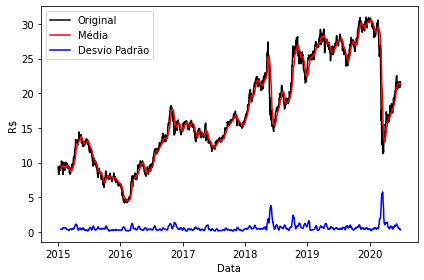

In [32]:
indice, serie, media_serie,std_serie = teste_estacionariedade(petr4_close)

In [43]:
# Comprovando com Teste de ADF e importando adfuller

from statsmodels.tsa.stattools import adfuller

print ('Results of Dickey-Fuller Test:')
dftest = adfuller(petr4_treino, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -0.699221
p-value                           0.846951
#Lags Used                        6.000000
Number of Observations Used    1234.000000
Critical Value (1%)              -3.435660
Critical Value (5%)              -2.863885
Critical Value (10%)             -2.568019
dtype: float64


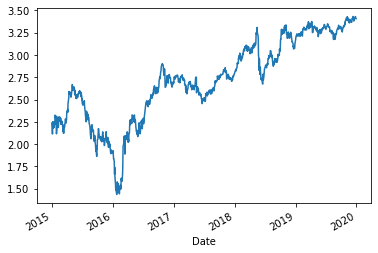

In [46]:
# Verificando se o log da série é estacionário
petr4_treino_log = np.log(petr4_treino)
petr4_treino_log.plot()

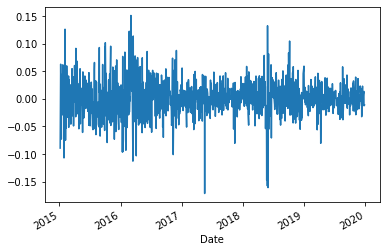

In [48]:
# Diferenciando a série log
petr4_treino_log_diff = petr4_treino_log - petr4_treino_log.shift()
petr4_treino_log_diff.plot()